In [28]:
import logging
from libdatasets import *
import librun
import libstop
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv
import time
import datetime
import libplot
from libplot import align_yaxis
import warnings
import ipywidgets as widgets
import matplotlib.pyplot as plt

load_dotenv()

True

In [21]:
warnings.filterwarnings('ignore')

In [130]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("rcv1-58509", wrap(rcv1, 58509)),
        ("webkb", wrap(webkb, None)),
        ("spamassassin", wrap(spamassassin, None)),
        ("avila", wrap(avila, None)),
        ("smartphone", wrap(smartphone, None)),
        ("swarm", wrap(swarm, None)),
        ("sensorless", wrap(sensorless, None)),
        ("splice", wrap(splice, None)),
        ("anuran", wrap(anuran, None)),
        
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("res500", lambda learner, matrix, state: state.X_unlabelled.shape[0] < 510),
        "pool_subsample": 1000
    }
}

s = time.monotonic()
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=29)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]
print("Retrieving classifier results took:", str(datetime.timedelta(seconds=time.monotonic()-s)))

['/home/zac/.cache/pypoetry/virtualenvs/research-vDwbEF2m-py3.8/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/home/zac/.local/share/jupyter/runtime/kernel-b71a5210-0c16-43e3-bcbd-4e7c68410eaa.json']
Current commit: d73b367



Experiment:   0%|          | 0/8 [00:00<?, ?it/s]

Retrieving classifier results took: 0:04:06.437419


In [131]:
from importlib import reload; import libstop; reload(libstop); from libstop import *

conditions = {
    #"GOAL": GOAL,
    #"SSNCut": SSNCut,
    #"SC_entropy_mcs": SC_entropy_mcs,
    #"SC_oracle_acc": SC_oracle_acc_mcs,
    #"SC_mes": SC_mes,
    #"Stabilizing Predictions": StabilizingPredictions,
    #"Performance Convergence": PerformanceConvergence,
    #"Uncertainty Convergence": UncertaintyConvergence,
    #"Max Confidence": MaxConfidence,
    #"EVM": EVM,
    #"VM": VM,
    #"Contradictory Information": ContradictoryInformation,
    #"Classification Change": ClassificationChange,
    #"Overall Uncertainty": OverallUncertainty,
    # Attempt 1
    #FirstDiffMinOverallUncertainty.__name__: FirstDiffMinOverallUncertainty,
    #FirstDiffZeroOverallUncertainty.__name__: FirstDiffZeroOverallUncertainty,
    #SecondDiffZeroOverallUncertainty.__name__: SecondDiffZeroOverallUncertainty,
    #FirstDiffZeroPerformanceConvergence.__name__: FirstDiffZeroPerformanceConvergence,
    #SecondDiffZeroPerformanceConvergence.__name__: SecondDiffZeroPerformanceConvergence,
    #FirstDiffZeroStabilizingPredictions.__name__+"-alpha1": partial(FirstDiffZeroStabilizingPredictions, alpha=1),
    # Attempt 2
    FirstDiffMinOverallUncertainty.__name__+"-weak": partial(FirstDiffMinOverallUncertainty, start_method="2"),
    FirstDiffZeroOverallUncertainty.__name__+"-weak": partial(FirstDiffZeroOverallUncertainty, start_method="2"),
    SecondDiffZeroOverallUncertainty.__name__+"-weak": partial(SecondDiffZeroOverallUncertainty, start_method="2"),
    FirstDiffZeroPerformanceConvergence.__name__+"-weak": partial(FirstDiffZeroPerformanceConvergence, start_method="2"),
    SecondDiffZeroPerformanceConvergence.__name__+"-weak": partial(SecondDiffZeroPerformanceConvergence, start_method="2"),
    FirstDiffZeroStabilizingPredictions.__name__+"-alpha1-weak": partial(FirstDiffZeroStabilizingPredictions, alpha=1, start_method="2"),
}

s = time.monotonic()
stop_conditions, stop_results = libstop.eval_stopping_conditions(
    results_plots, classifiers, conditions=conditions, recompute=[], save=False
)
print("Computing stop conditions took:", str(datetime.timedelta(seconds=time.monotonic()-s)))
results_filter = stop_results

Starting svm-linear webkb
Starting svm-linear spamassassin
Starting svm-linear avila
Starting svm-linear smartphone
Starting svm-linear swarm
Starting svm-linear sensorless
Starting svm-linear splice
Starting svm-linear anuran
Computing stop conditions took: 1:27:58.219955


In [126]:
conditions

{'FirstDiffMinOverallUncertainty-weak': functools.partial(<class 'libstop.FirstDiffMinOverallUncertainty'>, start_method='2'),
 'FirstDiffZeroOverallUncertainty-weak': functools.partial(<class 'libstop.FirstDiffZeroOverallUncertainty'>, start_method='2'),
 'SecondDiffZeroOverallUncertainty-weak': functools.partial(<class 'libstop.SecondDiffZeroOverallUncertainty'>, start_method='2'),
 'FirstDiffZeroPerformanceConvergence-weak': functools.partial(<class 'libstop.FirstDiffZeroPerformanceConvergence'>, start_method='2'),
 'SecondDiffZeroPerformanceConvergence-weak': functools.partial(<class 'libstop.SecondDiffZeroPerformanceConvergence'>, start_method='2'),
 'FirstDiffZeroStabilizingPredictions-alpha1-weak': functools.partial(<class 'libstop.FirstDiffZeroStabilizingPredictions'>, alpha=1, start_method='2')}

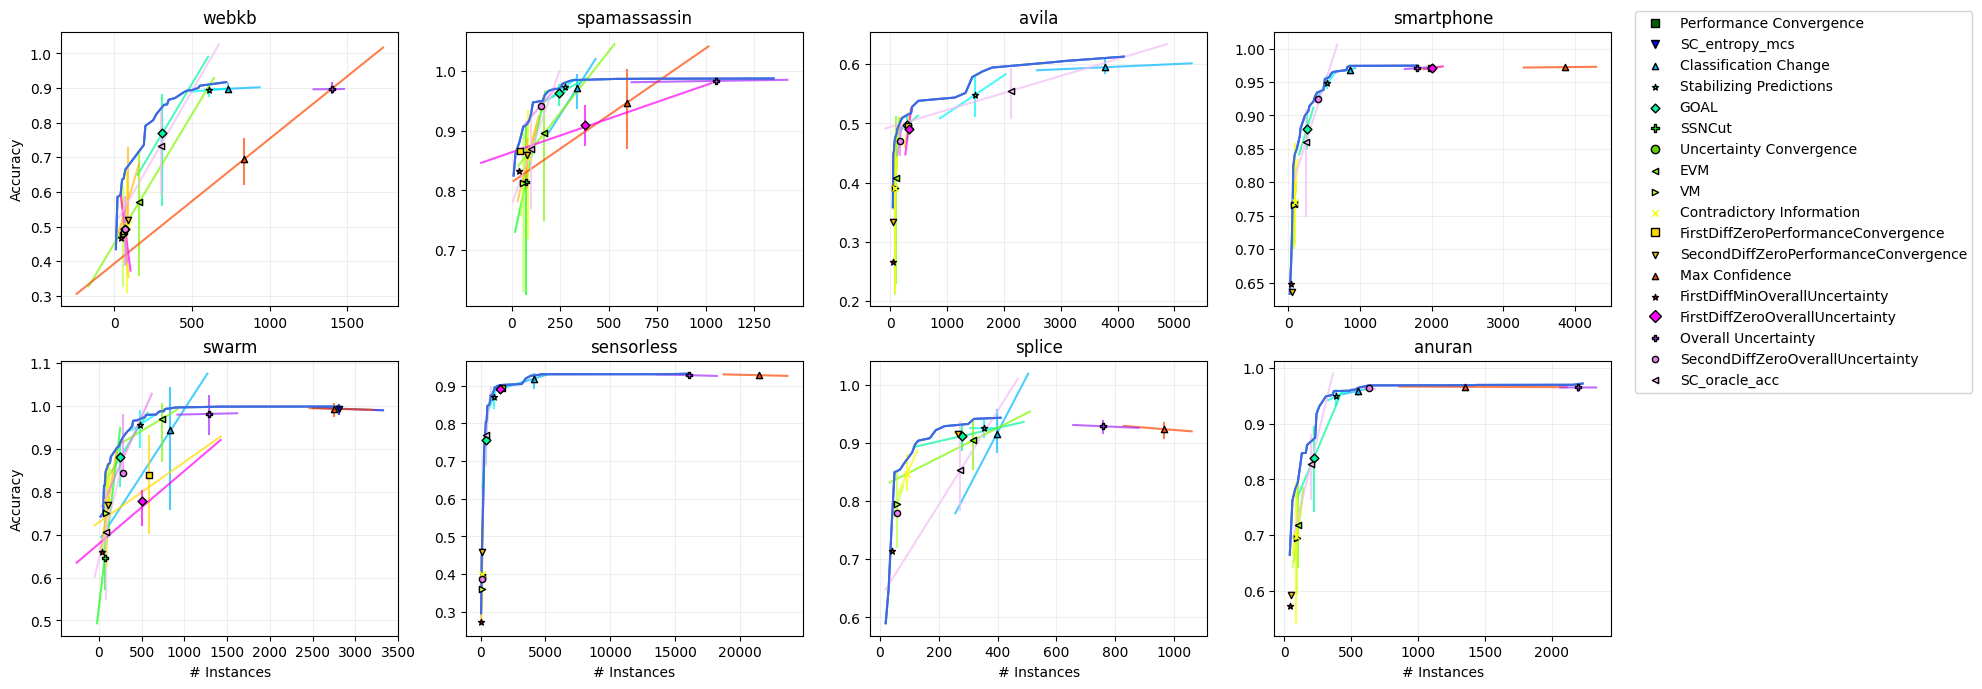

In [22]:
reload(libplot); from libplot import plot_paraeto_hull
with plt.style.context('plt_style.txt'):
    plot_paraeto_hull(results_filter, rows=2, cols=4, figsize=(15,6), dpi=100, hull=False, error='pca')

In [127]:
glob_runs = None
@widgets.interact(dataset=list(results_filter.keys()), criteria=list(list(results_filter.values())[0].keys()))
def explore(dataset: str, criteria: str):
    global glob_runs
    """
    Look at why a particular condition evaluated on a particular dataset gave certain results.
    """

    runs = results_filter[dataset][criteria]
    run_plots = [plots[1] for plots in results_plots if plots[0].dataset_name == dataset][0]
    #print(len(run_plots))
    #assert False
    x = run_plots[0].x
    accuracy_mean = np.mean([run_plot.accuracy_score for run_plot in run_plots], axis=0)
    accuracy_stderr = np.std([run_plot.accuracy_score for run_plot in run_plots], axis=0)
    f1_mean = np.mean([run_plot.f1_score for run_plot in run_plots], axis=0)
    f1_stderr = np.std([run_plot.f1_score for run_plot in run_plots], axis=0)
    roc_auc_mean = np.mean([run_plot.roc_auc_score for run_plot in run_plots], axis=0)
    roc_auc_stderr = np.std([run_plot.roc_auc_score for run_plot in run_plots], axis=0)
    lines = [(accuracy_mean, accuracy_stderr), (f1_mean, f1_stderr), (roc_auc_mean, roc_auc_stderr)]
    
    # Plot accuracy, metric, threshold stuff, possibly even some information about the criteria? Doc comment, paper link, etc.
    fig, axes = plt.subplots(1, 4, figsize=(18,4))
    
    for i, ax in enumerate(axes[:3]):
        line = ax.plot(x, lines[i][0])
        ax.fill_between(
            x,
            lines[i][0]-lines[i][1],
            lines[i][0]+lines[i][1],
            color=line[0].get_color(),
            alpha=0.2
        )
        ax.scatter([run[0] for run in runs], [run[i+1] for run in runs])
        ax.set_xlabel("Instances")
        ax.set_ylabel(["Accuracy", "F1", "ROC AUC"][i])
        
    stopped = np.count_nonzero([run[0] is not None for run in runs])
        
    #print(f"Metric example values: {runs[0][4]}")
    glob_runs = runs
    if runs[0][4] is not None:
        if isinstance(runs[0][4], tuple):
            # Multiple values returned by metric, we take the first and assume it's the right one to plot
            metric_mean = np.mean([run[4][0] for run in runs], axis=0)
            metric_stderr = np.std([run[4][0] for run in runs], axis=0)
            metric_shape = np.array(runs[0][4][0]).shape
        else:
            metric_mean = np.mean([run[4] for run in runs], axis=0)
            metric_stderr = np.std([run[4] for run in runs], axis=0)
            metric_shape = np.array(runs[0][4]).shape
    
        mean_line = axes[3].plot(np.arange(0, metric_shape[0]*10, 10), metric_mean)
        axes[3].fill_between(
            np.arange(0, metric_shape[0]*10, 10), 
            metric_mean-metric_stderr, 
            metric_mean+metric_stderr, 
            color=mean_line[0].get_color(), 
            alpha=0.2
        )
        axes[3].set_xlabel('Instances')
        axes[3].set_ylabel('Metric')
        
        if isinstance(runs[0][4], tuple) and criteria != "GOAL":
            axes4 = axes[3].twinx()
            for extra in range(1, len(runs[0][4])):
                print(f"Plotting extra metric {extra}")
                extra_mean = np.mean([run[4][extra] for run in runs], axis=0)
                extra_stderr = np.std([run[4][extra] for run in runs], axis=0)
                extra_shape = np.array(runs[0][4][extra]).shape
                extra_line = axes4.plot(np.arange(0, extra_shape[0]*10, 10), extra_mean)
                #print(runs[0][4][extra])
                axes4.fill_between(np.arange(0, metric_shape[0]*10, 10), extra_mean-extra_stderr,extra_mean+extra_stderr, color=extra_line[0].get_color(), alpha=0.2)
                
                if axes4.get_ylim()[0] < 0 and 0 < axes4.get_ylim()[1]:
                    axes4.axhline(-0.1, color='darkgrey', ls='--', alpha=0.8)
                    axes4.axhline(0.1, color='darkgrey', ls='--', alpha=0.8)
            #axes4.set_ylim(-2, 2)
            #align_yaxis(axes[3], axes4)
            
        
        if axes[3].get_ylim()[0] < 0 and 0 < axes[3].get_ylim()[1]:
            axes[3].axhline(0, color='grey', ls='--', alpha=0.8)
    
    fig.suptitle(f"{criteria} evaluated on {dataset}")
    
    fig.text(-0.1, -0.2, f"Criteria stopped on {stopped}/{len(runs)} runs", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    
    fig.tight_layout()

interactive(children=(Dropdown(description='dataset', options=('webkb', 'spamassassin', 'avila', 'smartphone',…

### All Metric Graphs

In [44]:
criteria = set.union(*[set(list(result.keys())) for result in results_filter.values()])

Plotting extra metric 1
Plotting extra metric 1
Plotting extra metric 1
Plotting extra metric 2
Plotting extra metric 1
Plotting extra metric 1
Plotting extra metric 1
Plotting extra metric 2


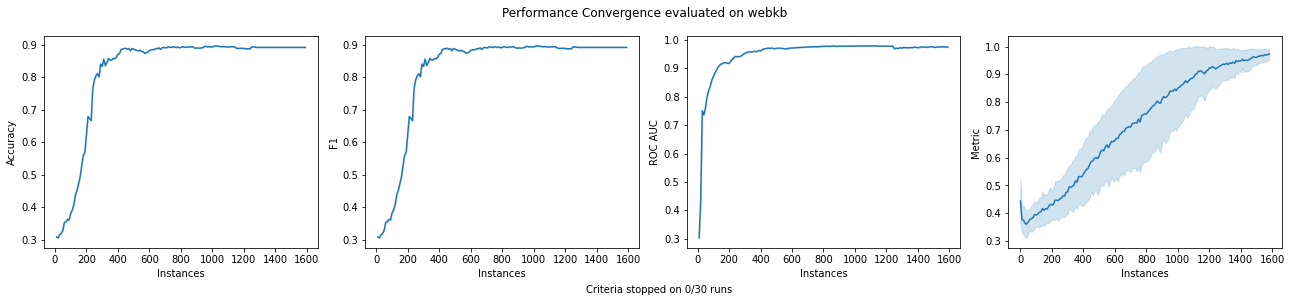

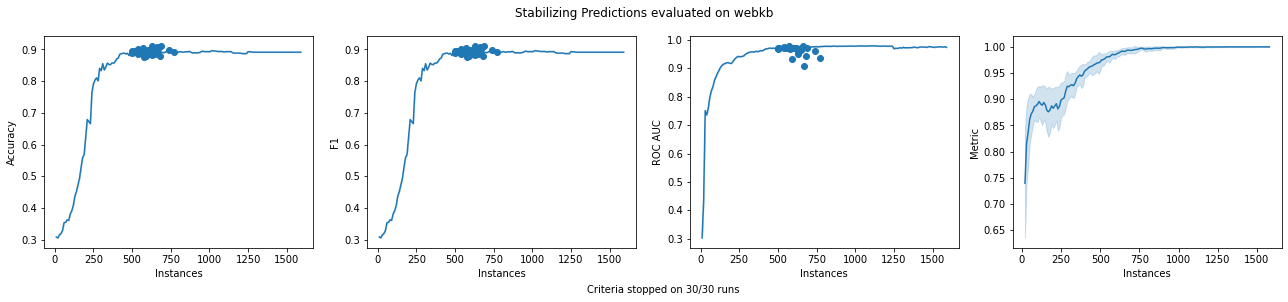

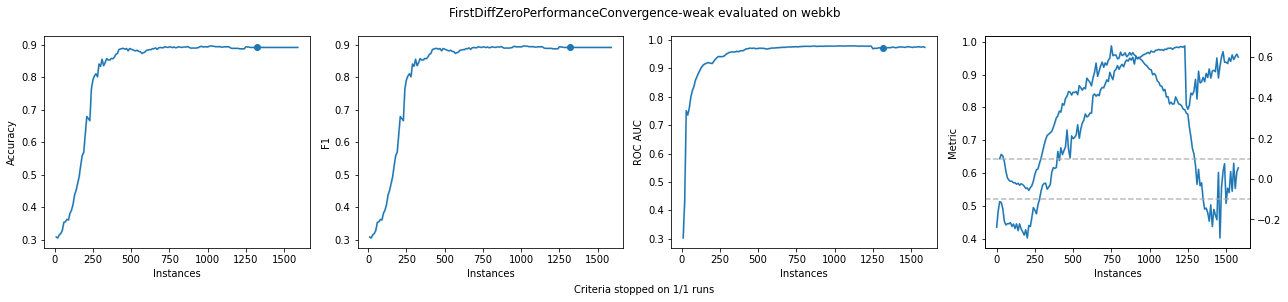

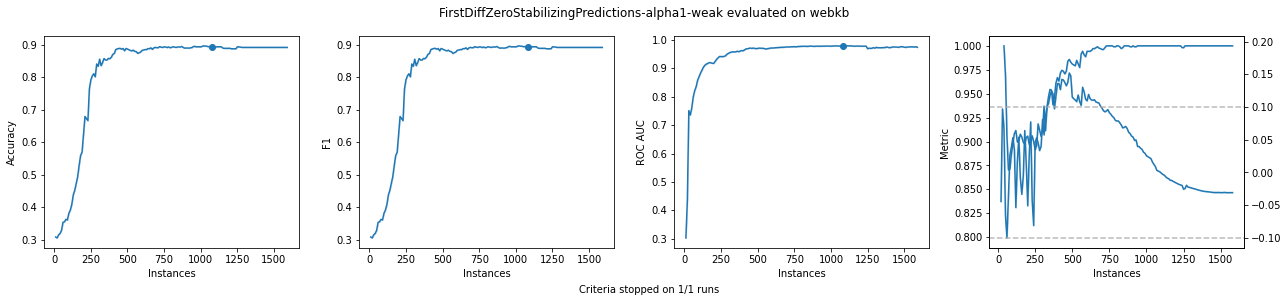

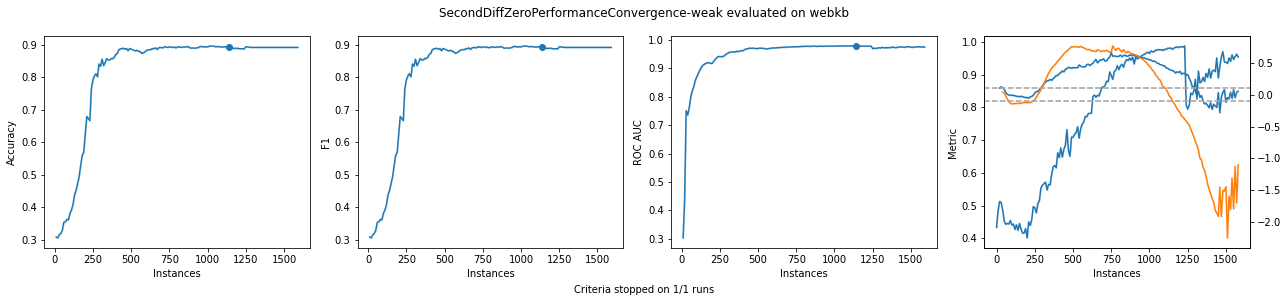

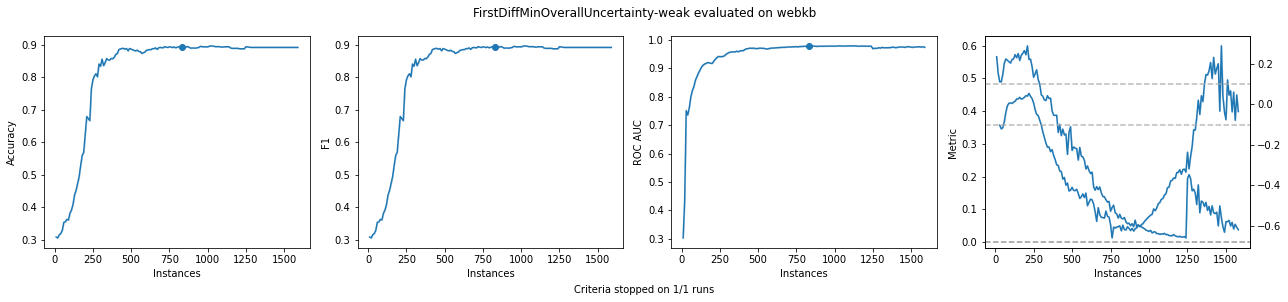

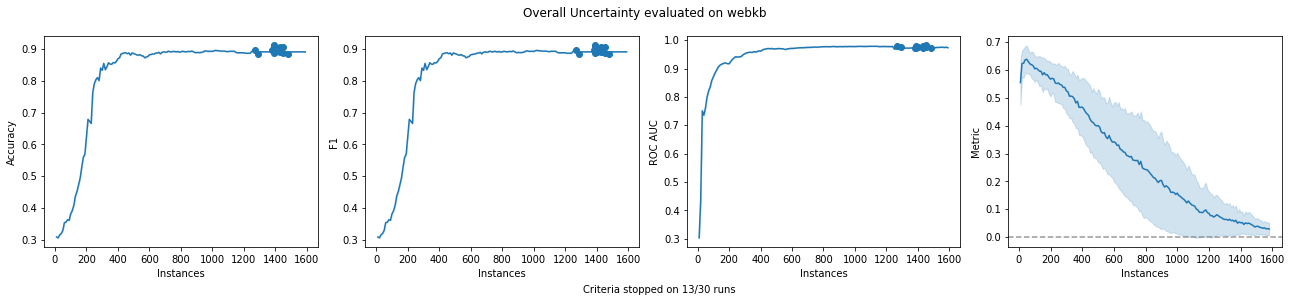

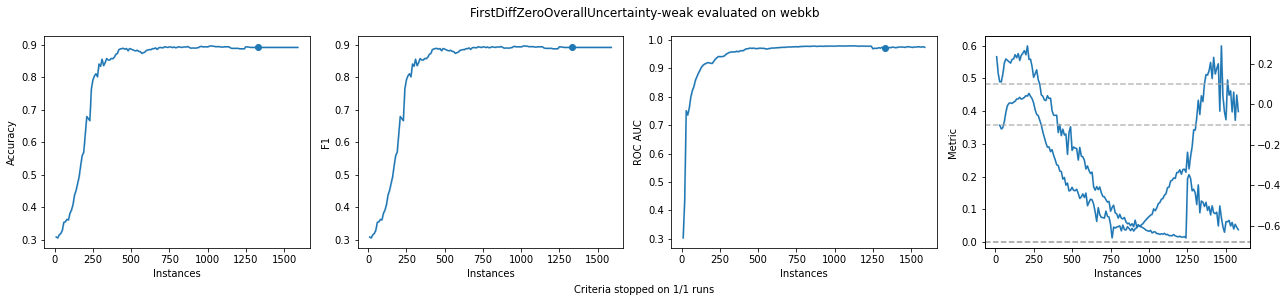

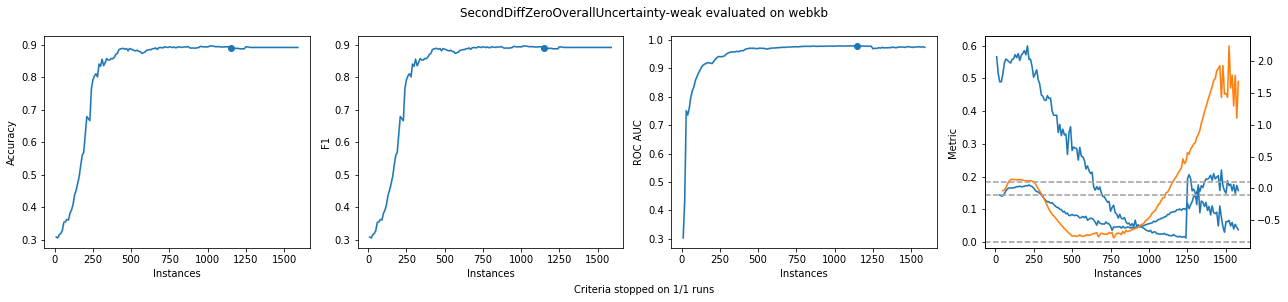

In [129]:
for c in set(conditions.keys()).union(set(('Overall Uncertainty', 'Performance Convergence', 'Stabilizing Predictions'))):
    explore('webkb', c)

### Region Plots

In [ ]:
reload(libregionplot); from libregionplot import regions, costs
with plt.style.context('plt_style.txt'):
    fig, axes = plt.subplots(1, 3, figsize=(7.2*1.2,4.45), dpi=300)
    patches = []
    for i, (ax, mode) in enumerate(zip(axes, ['penalty', 'include', 'exclude'])):
        regions(results_filter, colors=criteria_map, failed_to_stop=mode, title=mode.title(), ax=ax, patches=patches, left=i==0)
    plt.legend(handles=patches, bbox_to_anchor=(0.99, -0.3), ncol=3)
#plt.tight_layout()